Using device: cpu
Images directory exists: True
Masks directory exists: True
Number of images: 2594
Number of masks: 2594

Sample image filenames:
  ISIC_0000000.jpg
  ISIC_0000001.jpg
  ISIC_0000003.jpg
  ISIC_0000004.jpg
  ISIC_0000006.jpg

Sample mask filenames:
  ISIC_0000000_segmentation.png
  ISIC_0000001_segmentation.png
  ISIC_0000003_segmentation.png
  ISIC_0000004_segmentation.png
  ISIC_0000006_segmentation.png


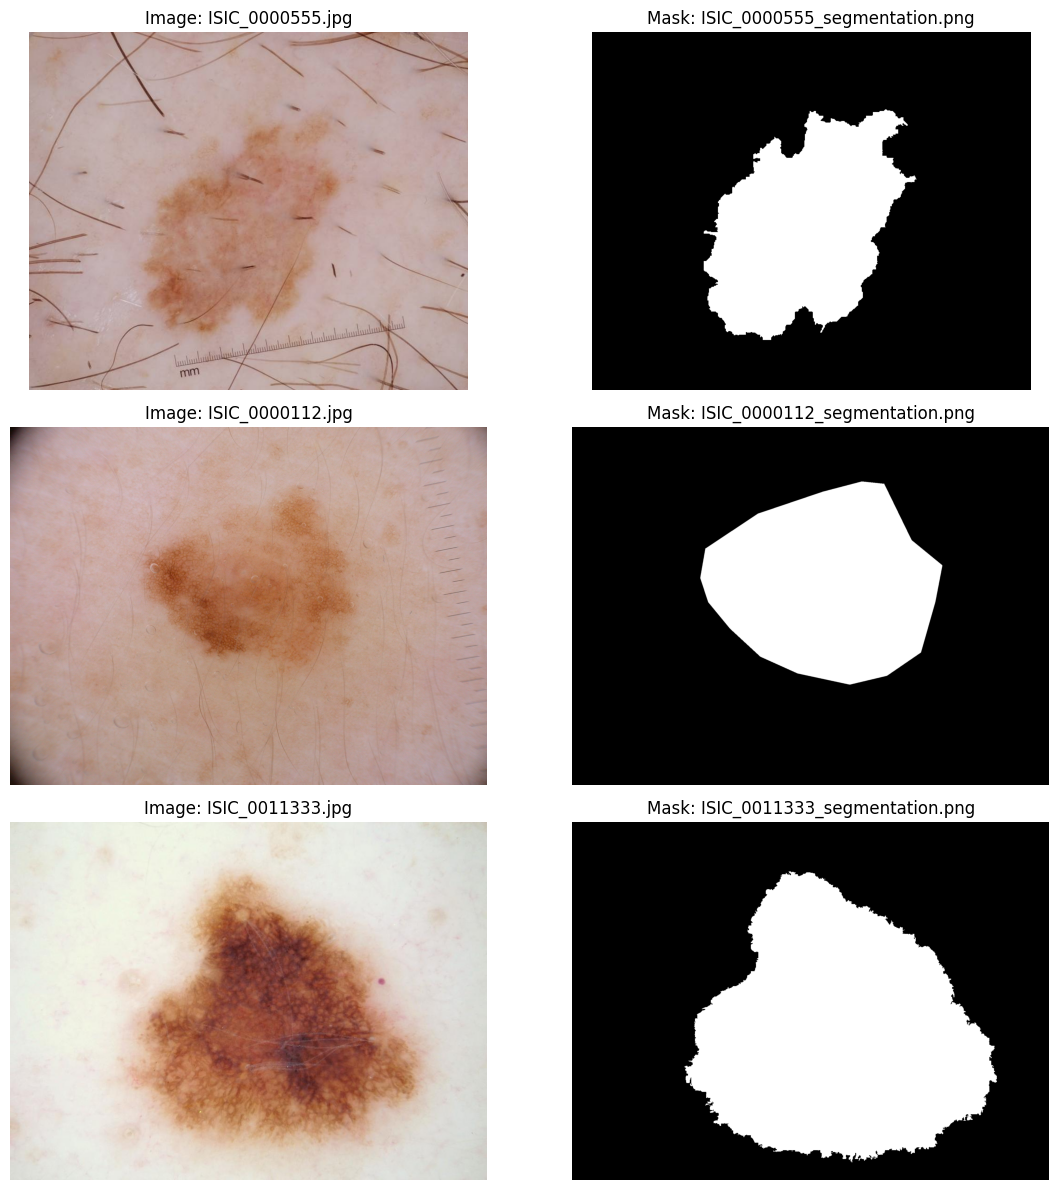

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from PIL import Image

# Set random seed
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

BASE_DIR = '../data/isic_2018_task1_data/'
IMAGES_DIR = os.path.join(BASE_DIR, 'ISIC2018_Task1-2_Training_Input')
MASKS_DIR = os.path.join(BASE_DIR, 'ISIC2018_Task1_Training_GroundTruth')

# Check paths and count files
print(f"Images directory exists: {os.path.exists(IMAGES_DIR)}")
print(f"Masks directory exists: {os.path.exists(MASKS_DIR)}")

if os.path.exists(IMAGES_DIR) and os.path.exists(MASKS_DIR):
    image_files = sorted([f for f in os.listdir(IMAGES_DIR) if f.endswith('.jpg')])
    mask_files = sorted([f for f in os.listdir(MASKS_DIR) if f.endswith('.png')])
    print(f"Number of images: {len(image_files)}")
    print(f"Number of masks: {len(mask_files)}")
    
    # Display sample filenames
    print("\nSample image filenames:")
    for i in range(min(5, len(image_files))):
        print(f"  {image_files[i]}")
    
    print("\nSample mask filenames:")
    for i in range(min(5, len(mask_files))):
        print(f"  {mask_files[i]}")

# Display a few sample images with masks
def display_samples(images_dir, masks_dir, num_samples=3):
    image_files = sorted([f for f in os.listdir(images_dir) if f.endswith('.jpg')])
    
    fig, axes = plt.subplots(num_samples, 2, figsize=(12, 4*num_samples))
    
    for i in range(num_samples):
        # Select a random image
        idx = random.randint(0, len(image_files)-1)
        img_file = image_files[idx]
        
        # Find corresponding mask (may have different naming convention)
        img_id = img_file.split('.')[0]
        mask_file = None
        
        # Look for matching mask file
        for mf in os.listdir(masks_dir):
            if img_id in mf and mf.endswith('.png'):
                mask_file = mf
                break
        
        if mask_file is None:
            print(f"Warning: No mask found for {img_file}")
            continue
        
        # Load image and mask
        img_path = os.path.join(images_dir, img_file)
        mask_path = os.path.join(masks_dir, mask_file)
        
        img = np.array(Image.open(img_path))
        mask = np.array(Image.open(mask_path))
        
        # Normalize mask to [0, 1] if necessary
        if mask.max() > 1:
            mask = mask / 255.0
        
        # Display
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"Image: {img_file}")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title(f"Mask: {mask_file}")
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

display_samples(IMAGES_DIR, MASKS_DIR)

In [4]:
import os
import sys
sys.path.append('../src')

import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
from sklearn.model_selection import train_test_split

# Import models from the src directory structure
from models.unet import UNet
from models.enhanced_unet import EnhancedUNet
from utils.losses import BCEDiceLoss
from utils.metrics import dice_coefficient, iou_coefficient

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

# Debug mode
DEBUG_MODE = False
SUBSET_SIZE = 100

In [5]:
class ISICDataset(Dataset):
    """ISIC 2018 Task 1 Dataset for Training"""
    def __init__(self, image_dir, mask_dir, size=(256, 256), transform=None, subset_size=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.size = size
        self.transform = transform
        
        # Get all image files
        all_image_files = sorted(os.listdir(image_dir))

        all_files = os.listdir(image_dir)
        valid_extensions = ('.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG')
        
        # Filter to get only image files
        all_image_files = sorted([f for f in all_files if f.endswith(valid_extensions)])
        
        print(f"Found {len(all_image_files)} image files out of {len(all_files)} total files")
        
        if subset_size and subset_size < len(all_image_files):
            self.image_files = all_image_files[:subset_size]
            print(f"Using subset of {subset_size} samples out of {len(all_image_files)} total")
        else:
            self.image_files = all_image_files
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        base_name = os.path.splitext(img_name)[0]
        mask_name = base_name + "_segmentation.png"
        mask_path = os.path.join(self.mask_dir, mask_name)
        
        try:
            # Load image and mask
            image = Image.open(img_path).convert("RGB")
            mask = Image.open(mask_path).convert("L")
            
            image = image.resize(self.size, Image.BILINEAR)
            mask = mask.resize(self.size, Image.NEAREST)
            
            image = np.array(image)
            mask = np.array(mask, dtype=np.float32)
            
            image = image / 255.0
            if mask.max() > 1:
                mask = mask / 255.0
                
            image = torch.from_numpy(image.transpose((2, 0, 1))).float()
            mask = torch.from_numpy(mask).unsqueeze(0).float()
            
            if self.transform:
                image, mask = self.transform(image, mask)
                
            return image, mask
        except Exception as e:
            print(f"Error loading {img_name}: {e}")
            image = torch.randn(3, *self.size)
            mask = torch.zeros(1, *self.size)
            return image, mask

In [6]:
# Define paths
train_image_dir = '../data/isic_2018_task1_data/ISIC2018_Task1-2_Training_Input/'
train_mask_dir = '../data/isic_2018_task1_data/ISIC2018_Task1_Training_GroundTruth/'

# Create dataset with optional subset
if DEBUG_MODE:
    full_dataset = ISICDataset(train_image_dir, train_mask_dir, size=(256, 256), subset_size=SUBSET_SIZE)
else:
    full_dataset = ISICDataset(train_image_dir, train_mask_dir, size=(256, 256))

print(f"Total dataset size: {len(full_dataset)}")

Found 2594 image files out of 2596 total files
Total dataset size: 2594


In [7]:
# Create train/validation split
train_ratio = 0.9
dataset_size = len(full_dataset)
indices = list(range(dataset_size))
split = int(np.floor(train_ratio * dataset_size))

# Set seed for reproducibility
np.random.seed(42)
np.random.shuffle(indices)

train_indices, val_indices = indices[:split], indices[split:]
print(f"Training samples: {len(train_indices)}")
print(f"Validation samples: {len(val_indices)}")

Training samples: 2334
Validation samples: 260


In [12]:
# Create samplers and dataloaders
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(full_dataset, batch_size=32, sampler=train_sampler, num_workers=0)  # num_workers=0 for debugging
val_loader = DataLoader(full_dataset, batch_size=32, sampler=val_sampler, num_workers=0)

# Test the dataloader
for batch_idx, (images, masks) in enumerate(train_loader):
    print(f"First batch: images shape: {images.shape}, masks shape: {masks.shape}")
    break

First batch: images shape: torch.Size([32, 3, 256, 256]), masks shape: torch.Size([32, 1, 256, 256])


In [15]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create models
baseline_model = UNet(n_channels=3, n_classes=1).to(device)
enhanced_model = EnhancedUNet(
    n_channels=3, 
    n_classes=1,
    use_se=True,  # Squeeze-and-Excitation blocks
    use_lightweight=True  # Depthwise separable convolutions
).to(device)

models = {
    'baseline_unet': baseline_model,
    'enhanced_unet': enhanced_model
}

print(f"Number of parameters in baseline model: {sum(p.numel() for p in baseline_model.parameters()):,}")
print(f"Number of parameters in enhanced model: {sum(p.numel() for p in enhanced_model.parameters()):,}")
import torch
print(f"GPU memory available: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
Number of parameters in baseline model: 31,037,633
Number of parameters in enhanced model: 6,206,364
GPU memory available: 23.66 GB


In [14]:
# Training configuration
num_epochs = 25
results = {}

for model_name, model in models.items():
    print(f"\n{'='*20} Training {model_name} model {'='*20}")
    
    # Initialize training components
    criterion = BCEDiceLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
    
    # Initialize metrics tracking
    train_losses = []
    val_losses = []
    val_dices = []
    val_ious = []
    learning_rates = []
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        # Track learning rate
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)
        
        # Training phase
        model.train()
        epoch_loss = 0
        batch_count = 0
        
        for images, masks in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False):
            images = images.to(device)
            masks = masks.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            batch_count += 1
        
        train_loss = epoch_loss / batch_count
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        epoch_loss = 0
        epoch_dice = 0
        epoch_iou = 0
        batch_count = 0
        
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, masks)
                dice = dice_coefficient(outputs, masks)
                iou = iou_coefficient(outputs, masks)
                
                epoch_loss += loss.item()
                epoch_dice += dice
                epoch_iou += iou
                batch_count += 1
        
        val_loss = epoch_loss / batch_count
        val_dice = epoch_dice / batch_count
        val_iou = epoch_iou / batch_count
        
        val_losses.append(val_loss)
        val_dices.append(val_dice)
        val_ious.append(val_iou)
        
        # Update scheduler
        scheduler.step(val_loss)
        
        # Print progress
        print(f'Epoch {epoch+1:3d}/{num_epochs} | LR: {current_lr:.6f} | '
              f'Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | '
              f'Val Dice: {val_dice:.4f} | Val IoU: {val_iou:.4f}')
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_dir = f'../saved_models/{model_name}/'
            os.makedirs(save_dir, exist_ok=True)
            torch.save(model.state_dict(), os.path.join(save_dir, 'best_model.pth'))
            
            # Save checkpoint
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_loss': val_loss,
            }, os.path.join(save_dir, 'checkpoint.pth'))
    
    # Save final model
    torch.save(model.state_dict(), os.path.join(save_dir, 'final_model.pth'))
    
    # Store results
    results[model_name] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_dices': val_dices,
        'val_ious': val_ious,
        'learning_rates': learning_rates,
        'best_val_loss': best_val_loss,
        'epochs': num_epochs
    }
    
    print(f"Completed training for {model_name} model")


==================== Training baseline model ====================


Epoch   1/25 | LR: 0.000100 | Train Loss: 0.8818 | Val Loss: 0.8022 | Val Dice: 0.7467 | Val IoU: 0.5988


Epoch   2/25 | LR: 0.000100 | Train Loss: 0.6735 | Val Loss: 0.7087 | Val Dice: 0.7830 | Val IoU: 0.6446


Epoch   3/25 | LR: 0.000100 | Train Loss: 0.5983 | Val Loss: 0.5962 | Val Dice: 0.8164 | Val IoU: 0.6933


Epoch   4/25 | LR: 0.000100 | Train Loss: 0.5384 | Val Loss: 0.5540 | Val Dice: 0.8168 | Val IoU: 0.6930


Epoch   5/25 | LR: 0.000100 | Train Loss: 0.4976 | Val Loss: 0.5234 | Val Dice: 0.8124 | Val IoU: 0.6864


Epoch   6/25 | LR: 0.000100 | Train Loss: 0.4736 | Val Loss: 0.5027 | Val Dice: 0.8134 | Val IoU: 0.6893


Epoch   7/25 | LR: 0.000100 | Train Loss: 0.4305 | Val Loss: 0.5244 | Val Dice: 0.8114 | Val IoU: 0.6927


Epoch   8/25 | LR: 0.000100 | Train Loss: 0.4035 | Val Loss: 0.4410 | Val Dice: 0.8373 | Val IoU: 0.7214


Epoch   9/25 | LR: 0.000100 | Train Loss: 0.3920 | Val Loss: 0.4269 | Val Dice: 0.8487 | Val IoU: 0.7389


Epoch  10/25 | LR: 0.000100 | Train Loss: 0.3670 | Val Loss: 0.3962 | Val Dice: 0.8583 | Val IoU: 0.7533


Epoch  11/25 | LR: 0.000100 | Train Loss: 0.3543 | Val Loss: 0.3952 | Val Dice: 0.8530 | Val IoU: 0.7474


Epoch  12/25 | LR: 0.000100 | Train Loss: 0.3349 | Val Loss: 0.4215 | Val Dice: 0.8222 | Val IoU: 0.7042


Epoch  13/25 | LR: 0.000100 | Train Loss: 0.3314 | Val Loss: 0.3602 | Val Dice: 0.8616 | Val IoU: 0.7595


Epoch  14/25 | LR: 0.000100 | Train Loss: 0.3088 | Val Loss: 0.3869 | Val Dice: 0.8484 | Val IoU: 0.7404


Epoch  15/25 | LR: 0.000100 | Train Loss: 0.3001 | Val Loss: 0.3903 | Val Dice: 0.8554 | Val IoU: 0.7494


Epoch  16/25 | LR: 0.000100 | Train Loss: 0.2951 | Val Loss: 0.3576 | Val Dice: 0.8602 | Val IoU: 0.7559


Epoch  17/25 | LR: 0.000100 | Train Loss: 0.2811 | Val Loss: 0.3601 | Val Dice: 0.8558 | Val IoU: 0.7518


Epoch  18/25 | LR: 0.000100 | Train Loss: 0.2684 | Val Loss: 0.3537 | Val Dice: 0.8599 | Val IoU: 0.7552


Epoch  19/25 | LR: 0.000100 | Train Loss: 0.2639 | Val Loss: 0.3638 | Val Dice: 0.8476 | Val IoU: 0.7384


Epoch  20/25 | LR: 0.000100 | Train Loss: 0.2643 | Val Loss: 0.3596 | Val Dice: 0.8524 | Val IoU: 0.7446


Epoch  21/25 | LR: 0.000100 | Train Loss: 0.2604 | Val Loss: 0.3688 | Val Dice: 0.8537 | Val IoU: 0.7472


Epoch  22/25 | LR: 0.000100 | Train Loss: 0.2536 | Val Loss: 0.3736 | Val Dice: 0.8352 | Val IoU: 0.7286


Epoch  23/25 | LR: 0.000100 | Train Loss: 0.2409 | Val Loss: 0.3253 | Val Dice: 0.8682 | Val IoU: 0.7703


Epoch  24/25 | LR: 0.000100 | Train Loss: 0.2378 | Val Loss: 0.3449 | Val Dice: 0.8614 | Val IoU: 0.7583


Epoch  25/25 | LR: 0.000100 | Train Loss: 0.2316 | Val Loss: 0.3259 | Val Dice: 0.8708 | Val IoU: 0.7777
Completed training for baseline model

==================== Training enhanced model ====================


Epoch   1/25 | LR: 0.000100 | Train Loss: 1.2139 | Val Loss: 1.0767 | Val Dice: 0.7906 | Val IoU: 0.6571


Epoch   2/25 | LR: 0.000100 | Train Loss: 0.9995 | Val Loss: 0.9618 | Val Dice: 0.7695 | Val IoU: 0.6281


Epoch   3/25 | LR: 0.000100 | Train Loss: 0.8942 | Val Loss: 0.8719 | Val Dice: 0.8155 | Val IoU: 0.6894


Epoch   4/25 | LR: 0.000100 | Train Loss: 0.8211 | Val Loss: 0.8441 | Val Dice: 0.8022 | Val IoU: 0.6841


Epoch   5/25 | LR: 0.000100 | Train Loss: 0.7451 | Val Loss: 0.7479 | Val Dice: 0.8358 | Val IoU: 0.7200


Epoch   6/25 | LR: 0.000100 | Train Loss: 0.6778 | Val Loss: 0.7362 | Val Dice: 0.8044 | Val IoU: 0.6800


Epoch   7/25 | LR: 0.000100 | Train Loss: 0.6204 | Val Loss: 0.6028 | Val Dice: 0.8522 | Val IoU: 0.7451


Epoch   8/25 | LR: 0.000100 | Train Loss: 0.5484 | Val Loss: 0.6001 | Val Dice: 0.8449 | Val IoU: 0.7332


Epoch   9/25 | LR: 0.000100 | Train Loss: 0.5072 | Val Loss: 0.5185 | Val Dice: 0.8457 | Val IoU: 0.7355


Epoch  10/25 | LR: 0.000100 | Train Loss: 0.4408 | Val Loss: 0.4706 | Val Dice: 0.8720 | Val IoU: 0.7755


Epoch  11/25 | LR: 0.000100 | Train Loss: 0.4040 | Val Loss: 0.5547 | Val Dice: 0.8021 | Val IoU: 0.6975


Epoch  12/25 | LR: 0.000100 | Train Loss: 0.3756 | Val Loss: 0.4165 | Val Dice: 0.8669 | Val IoU: 0.7669


Epoch  13/25 | LR: 0.000100 | Train Loss: 0.3374 | Val Loss: 0.3998 | Val Dice: 0.8608 | Val IoU: 0.7595


Epoch  14/25 | LR: 0.000100 | Train Loss: 0.3080 | Val Loss: 0.3886 | Val Dice: 0.8662 | Val IoU: 0.7657


Epoch  15/25 | LR: 0.000100 | Train Loss: 0.2804 | Val Loss: 0.3739 | Val Dice: 0.8649 | Val IoU: 0.7646


Epoch  16/25 | LR: 0.000100 | Train Loss: 0.2601 | Val Loss: 0.3416 | Val Dice: 0.8731 | Val IoU: 0.7769


Epoch  17/25 | LR: 0.000100 | Train Loss: 0.2389 | Val Loss: 0.4020 | Val Dice: 0.8427 | Val IoU: 0.7306


Epoch  18/25 | LR: 0.000100 | Train Loss: 0.2287 | Val Loss: 0.4014 | Val Dice: 0.8387 | Val IoU: 0.7300


Epoch  19/25 | LR: 0.000100 | Train Loss: 0.2079 | Val Loss: 0.3341 | Val Dice: 0.8718 | Val IoU: 0.7743


Epoch  20/25 | LR: 0.000100 | Train Loss: 0.1931 | Val Loss: 0.3629 | Val Dice: 0.8628 | Val IoU: 0.7600


Epoch  21/25 | LR: 0.000100 | Train Loss: 0.1872 | Val Loss: 0.3322 | Val Dice: 0.8694 | Val IoU: 0.7710


Epoch  22/25 | LR: 0.000100 | Train Loss: 0.1720 | Val Loss: 0.3102 | Val Dice: 0.8772 | Val IoU: 0.7837


Epoch  23/25 | LR: 0.000100 | Train Loss: 0.1644 | Val Loss: 0.4437 | Val Dice: 0.8208 | Val IoU: 0.7026


Epoch  24/25 | LR: 0.000100 | Train Loss: 0.1645 | Val Loss: 0.3200 | Val Dice: 0.8715 | Val IoU: 0.7739


Epoch  25/25 | LR: 0.000100 | Train Loss: 0.1558 | Val Loss: 0.3308 | Val Dice: 0.8651 | Val IoU: 0.7640
Completed training for enhanced model
